In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot 
from bs4 import BeautifulSoup


In [17]:
def coalesce_list(val):
    if isinstance(val, list):
        return [str(x) for x in val if x not in (None, "", float("nan"))]
    if pd.isna(val):
        return []
    return [str(val)]

def format_section(label, values):
    values = coalesce_list(values)
    return f"{label}: " + ", ".join(values) if values else ""
 
def clean_html(text):
        if not isinstance(text, str):
            return text
        return BeautifulSoup(text, "html.parser").get_text(separator=" ", strip=True)
def to_tuple(x):
        if isinstance(x, list):
            return tuple(x)
        if pd.isna(x):
            return tuple()
        return x

In [20]:
import glob

In [33]:
lists_groups=  [
        "city_ids", "city_names",
        "skill_ids", "skill_names",
        "sector_ids", "sector_names",
    ]
v_cols = ['vacant_id', 'vacant_description',
        'min_salary', 'max_salary', 'city_ids', 'city_names', 'skill_ids',
        'skill_names', 'sector_ids', 'sector_names', "publish_date", "remote"]
cities = pd.read_json("../files/raw/cities_col.json")
city_map = cities.set_index("id")["location"].to_dict()

def read_vacants(file):
        df = pd.read_json(file)
        vacants_dedup = df
        vacants_dedup["vacant_description"] = vacants_dedup["vacant_description"].map(clean_html)
        vacants_dedup["full_text"] = vacants_dedup["vacant_description"]
        return vacants_dedup

def trannsform_cols(vacants_dedup):
        columnas = {'skill_names':" habilidades", 'sector_names':" sectores"}
        vacants_dedup["vacant_description"] = (
        vacants_dedup["vacant_description"].map(clean_html).fillna("")
        )
        for col in columnas:
              vacants_dedup[col] = vacants_dedup[col].fillna("") 
              print(col)
              col_ = vacants_dedup[col].apply(lambda x: format_section(columnas[col], x) if len(x)>0 else "")
              vacants_dedup["full_text"] += col_
        vacants_dedup["full_text"] = vacants_dedup["full_text"] + vacants_dedup["min_salary"].apply(lambda x: " salario: " + str(x)) 
        vacants_dedup= vacants_dedup[["full_text", "city_names","city_ids", "min_salary", "vacant_id","publish_date", "remote"]]
        vacants_dedup=vacants_dedup[~vacants_dedup["full_text"].isna()]

        vacants_dedup["city_loc"] = vacants_dedup["city_ids"].apply(  lambda ids: [city_map.get(i) for i in (ids if isinstance(ids, (list, tuple, set)) else [ids])]
       )
        return vacants_dedup

In [34]:
files = glob.glob("../files/batches_vacants/*")
files

['../files/batches_vacants\\batch_0.json']

In [35]:
frames = [read_vacants(file) for file in files]

In [36]:
frames_ = [trannsform_cols(vs) for vs in frames]

skill_names
sector_names


In [37]:
vacants = pd.concat(frames_)

In [38]:
print(vacants["full_text"][0])

Importante empresa requiere personal con o sin experiencia Salario Minimo + comisiones + auxilio de comunicación Tipo de Obra Obra labor Nivel Educativo Bachiller academico Funciones * Disponibilidad de trasladarse a cualquier parte de la ciudad *Disponibilidad de ingreso para atender clientes en Canal Moderno *Experiencia en empresas de consumo masivo realizando el cargo de Mercaderista. * Disponibilidad de madrugar a selectivos, cíclicos o ajuste de horarios de acuerdo a las políticas de cada almacén. * Disponibilidad de Horario requerimiento de clientes para selectivos, modulaciones otros 6 am cumpliendo con la jornada de 8 hrs. sectores: Otras salario: 1160000.0


<Axes: >

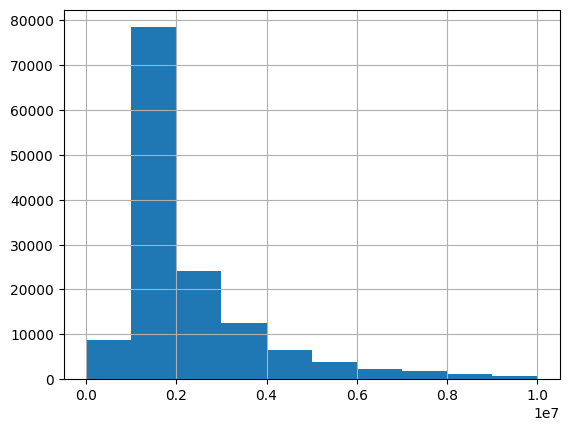

In [39]:
# salarios de candidatos
vacants[vacants["min_salary"]<10000000]["min_salary"].hist()

In [40]:
vacants["len_text"]=vacants["full_text"].apply(lambda x: len(x.split(" ")))

<Axes: >

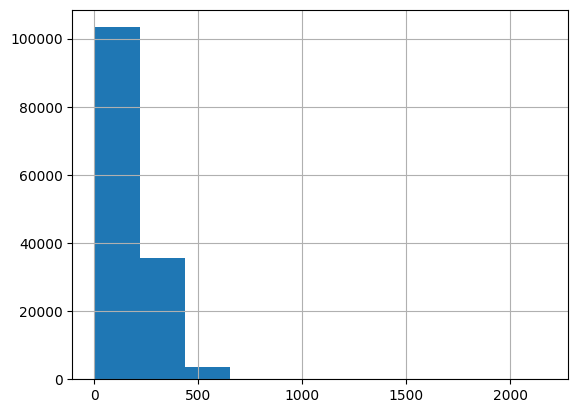

In [41]:
vacants[vacants["len_text"]>0]["len_text"].hist()

In [42]:
vacants.reset_index(drop=True).to_json("../files/raw/vacants.json")
